In [761]:
from scipy.optimize import curve_fit
import pandas

In [762]:
data = pandas.read_csv('data/winequality-red.csv', sep=';')

In [562]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [709]:
data.cov()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,3.031416,-0.079851,0.227820,0.281756,0.007679,-2.800921,-6.482346,0.002195,-0.183586,0.054010,-0.114421,0.174424
volatile acidity,-0.079851,0.032062,-0.019272,0.000484,0.000517,-0.019674,0.450426,0.000007,0.006495,-0.007921,-0.038600,-0.056476
citric acid,0.227820,-0.019272,0.037947,0.039434,0.001869,-0.124252,0.227697,0.000134,-0.016298,0.010328,0.022815,0.035612
residual sugar,0.281756,0.000484,0.039434,1.987897,0.003690,2.758611,9.416441,0.000945,-0.018644,0.001321,0.063219,0.015635
chlorides,0.007679,0.000517,0.001869,0.003690,0.002215,0.002738,0.073387,0.000018,-0.001926,0.002962,-0.011092,-0.004900
free sulfur dioxide,-2.800921,-0.019674,-0.124252,2.758611,0.002738,109.414884,229.737521,-0.000433,0.113653,0.091592,-0.773698,-0.427907
total sulfur dioxide,-6.482346,0.450426,0.227697,9.416441,0.073387,229.737521,1082.102373,0.004425,-0.337699,0.239471,-7.209298,-4.917237
density,0.002195,0.000007,0.000134,0.000945,0.000018,-0.000433,0.004425,0.000004,-0.000100,0.000048,-0.000998,-0.000267
pH,-0.183586,0.006495,-0.016298,-0.018644,-0.001926,0.113653,-0.337699,-0.000100,0.023835,-0.005146,0.033832,-0.007198
sulphates,0.054010,-0.007921,0.010328,0.001321,0.002962,0.091592,0.239471,0.000048,-0.005146,0.028733,0.016907,0.034413


In [220]:
data.columns

Index([u'fixed acidity', u'volatile acidity', u'citric acid',
       u'residual sugar', u'chlorides', u'free sulfur dioxide',
       u'total sulfur dioxide', u'density', u'pH', u'sulphates', u'alcohol',
       u'quality'],
      dtype='object')

In [826]:
variables = [u'fixed acidity', u'volatile acidity', u'citric acid',
       u'residual sugar', u'chlorides', u'free sulfur dioxide',
       u'total sulfur dioxide', u'density', u'pH', u'sulphates', u'alcohol']

## The Numpy Way

In [567]:
import numpy as np

In [763]:
X = data[variables].values
N, p = X.shape
X = np.hstack((np.repeat(1, N).reshape(-1,1), X))
XTXi = np.linalg.inv(np.dot(X.transpose(), X))
theta = np.dot(np.dot(XTXi, X.transpose()), data['quality'])

In [764]:
theta

array([  2.19652084e+01,   2.49905527e-02,  -1.08359026e+00,
        -1.82563948e-01,   1.63312698e-02,  -1.87422516e+00,
         4.36133331e-03,  -3.26457970e-03,  -1.78811638e+01,
        -4.13653144e-01,   9.16334413e-01,   2.76197699e-01])

In [765]:
sigma = 1. / (N - p - 1) * sum((f(data, *theta) - data['quality'])**2)
var_theta = np.dot(XTXi, sigma)

In [778]:
d_theta = np.sqrt(var_theta.diagonal())

In [779]:
from scipy.stats import t

In [780]:
print " ".join(["{:>12}".format(i) for i in ('name', 'coef', 'std', 't value', 'Pr(>|t|)')])
for c, dc, name in zip(theta, d_theta, ['const.'] + variables):
    print "{:>12}".format(name[:10]),
    print " ".join(["{:>12f}".format(i) for i in (c, dc, c/dc)]),
    Pz = 2*t.sf(abs(c/dc), len(data) - 5)
    if Pz < 1e-16:
        print " {:>10}".format("< 1e-16"),
    else:
        print " {:>10.2e}".format(Pz),
    if Pz < 0.05:
        print "***"
    else:
        print

        name         coef          std      t value     Pr(>|t|)
      const.    21.965208    21.194575     1.036360    3.00e-01
  fixed acid     0.024991     0.025949     0.963083    3.36e-01
  volatile a    -1.083590     0.121101    -8.947802     < 1e-16 ***
  citric aci    -0.182564     0.147176    -1.240445    2.15e-01
  residual s     0.016331     0.015002     1.088599    2.76e-01
   chlorides    -1.874225     0.419283    -4.470070    8.37e-06 ***
  free sulfu     0.004361     0.002171     2.008635    4.47e-02 ***
  total sulf    -0.003265     0.000729    -4.479830    8.00e-06 ***
     density   -17.881164    21.633100    -0.826565    4.09e-01
          pH    -0.413653     0.191597    -2.158971    3.10e-02 ***
   sulphates     0.916334     0.114337     8.014297    2.12e-15 ***
     alcohol     0.276198     0.026484    10.429014     < 1e-16 ***


## The Scipy Way

In [782]:
def f(x, t0, *thetas):
    return t0 + sum(theta*x[var] for theta, var in zip(thetas, variables))

In [783]:
res = curve_fit(f, data, data['quality'], [0]*(1 + len(variables)))

In [784]:
beta, pcov = res

In [785]:
beta

array([  2.19653301e+01,   2.49906306e-02,  -1.08359008e+00,
        -1.82563521e-01,   1.63314268e-02,  -1.87422509e+00,
         4.36132687e-03,  -3.26457963e-03,  -1.78812884e+01,
        -4.13652342e-01,   9.16334599e-01,   2.76197562e-01])

In [786]:
pcov.diagonal()

array([  4.49209945e+02,   6.73324475e-04,   1.46655176e-02,
         2.16608296e-02,   2.25062886e-04,   1.75798399e-01,
         4.71450769e-06,   5.31045264e-07,   4.67990950e+02,
         3.67095651e-02,   1.30730555e-02,   7.01380731e-04])

In [787]:
sigmab = np.sqrt(pcov.diagonal())

# Subset Selection and Shrinkage

## Best Subsets

In [308]:
from itertools import combinations
from sklearn.linear_model import LinearRegression

In [666]:
from sklearn.model_selection import train_test_split

In [716]:
train, test = train_test_split(data, test_size=0.2)

In [319]:
def LinRSS(X, y):
    f = LinearRegression().fit(X, y)
    return sum((f.predict(X) - y)**2)

In [320]:
RSS = {}
for i in range(1, len(variables) + 1):
    RSS[i] = {}
    for subset in combinations(variables, i):
        RSS[i][subset] = LinRSS(data[list(subset)], data['quality'])

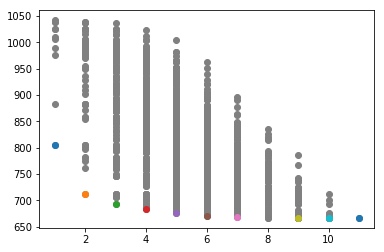

In [791]:
for i in RSS:
    plt.plot([i]*len(RSS[i]), RSS[i].values(), 'o', color='grey')
    plt.plot([i], min(RSS[i].values()), 'o')

## Forward stepwise

In [347]:
RSS_fwd = []
current = []
while len(current) != len(variables):
    candidates = [v for v in variables if v not in current]
    RSS_new = pandas.Series([LinRSS(data[current + [c]], data.quality)
                             for c in candidates], index=candidates)
    RSS_fwd.append(RSS_new.min())
    current.append(RSS_new.idxmin())

In [335]:
current, RSS_fwd

([u'alcohol',
  u'volatile acidity',
  u'sulphates',
  u'total sulfur dioxide',
  u'chlorides',
  u'pH',
  u'free sulfur dioxide',
  u'citric acid',
  u'residual sugar',
  u'fixed acidity',
  u'density'],
 [805.87045704866068,
  711.79623010230307,
  692.10464256122589,
  683.8870559473952,
  675.8500738507106,
  669.93119145569938,
  667.53705905577419,
  667.06225570453614,
  666.80557525141273,
  666.69759281696395,
  666.41070038703242])

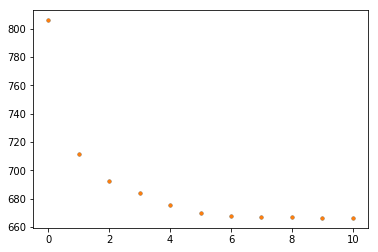

In [338]:
plt.plot(RSS_fwd, '.')
plt.plot([min(RSS[i].values()) for i in RSS], '.')

## Backward Stepwise

In [349]:
current = list(variables)
RSS_bwd = []
while len(current) > 1:
    RSS_current = pandas.Series([LinRSS(data[[i for i in current if i != c]], data.quality) for c in current],
                               index=current)
    current.remove(RSS_current.idxmin())
    RSS_bwd.append(RSS_current.min())

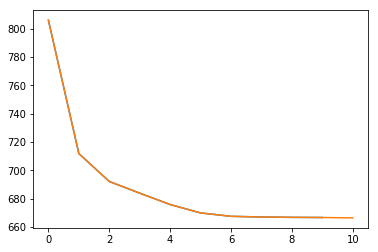

In [350]:
plt.plot(RSS_bwd[::-1])
plt.plot(RSS_fwd)

## Ignore This

In [295]:
def D(theta):
    return f(data, *theta) - data.quality

In [296]:
from scipy.optimize import leastsq

In [790]:
res = leastsq(D, [0]*(1 + len(variables)), full_output=True)

In [305]:
(res[1] * np.sum((res[2]['fvec'])**2)/len(data.quality)).diagonal()

array([  4.45838763e+02,   6.68271383e-04,   1.45554574e-02,
         2.14982718e-02,   2.23373859e-04,   1.74479086e-01,
         4.67912677e-06,   5.27059934e-07,   4.64478823e+02,
         3.64340712e-02,   1.29749463e-02,   6.96117086e-04])

In [306]:
beta, pcov.diagonal()

(array([  2.19653301e+01,   2.49906306e-02,  -1.08359008e+00,
         -1.82563521e-01,   1.63314268e-02,  -1.87422509e+00,
          4.36132687e-03,  -3.26457963e-03,  -1.78812884e+01,
         -4.13652342e-01,   9.16334599e-01,   2.76197562e-01]),
 array([  4.49209945e+02,   6.73324475e-04,   1.46655176e-02,
          2.16608296e-02,   2.25062886e-04,   1.75798399e-01,
          4.71450769e-06,   5.31045264e-07,   4.67990950e+02,
          3.67095651e-02,   1.30730555e-02,   7.01380731e-04]))

## Ridge

### Center data points

 name         coef          std      t value     Pr(>|t|)
      const.    21.965208    21.194575     1.036360    3.00e-01
  fixed acid     0.024991     0.025949     0.963083    3.36e-01
  volatile a    -1.083590     0.121101    -8.947802     < 1e-16 ***
  citric aci    -0.182564     0.147176    -1.240445    2.15e-01
  residual s     0.016331     0.015002     1.088599    2.76e-01
   chlorides    -1.874225     0.419283    -4.470070    8.37e-06 ***
  free sulfu     0.004361     0.002171     2.008635    4.47e-02 ***
  total sulf    -0.003265     0.000729    -4.479830    8.00e-06 ***
     density   -17.881164    21.633100    -0.826565    4.09e-01
          pH    -0.413653     0.191597    -2.158971    3.10e-02 ***
   sulphates     0.916334     0.114337     8.014297    2.12e-15 ***
     alcohol     0.276198     0.026484    10.429014     < 1e-16 ***


In [810]:
variables

[u'fixed acidity',
 u'volatile acidity',
 u'citric acid',
 u'residual sugar',
 u'chlorides',
 u'free sulfur dioxide',
 u'total sulfur dioxide',
 u'density',
 u'pH',
 u'sulphates',
 u'alcohol']

In [811]:
variables = [u'volatile acidity',
             u'chlorides',
             u'free sulfur dioxide',
 u'total sulfur dioxide',
             u'pH',
 u'sulphates',
 u'alcohol']

In [827]:
data = pandas.read_csv('data/winequality-red.csv', sep=';')
for column in variables:
    mean, sigma = data[column].mean(), data[column].std()
    data[column] = (data[column] - mean) / sigma

In [828]:
theta0 = np.mean(data['quality'])

In [686]:
train, test = train_test_split(data, test_size=0.2)

In [829]:
def f_ridge(x, *thetas):
    return theta0 + sum(theta*x[var] for theta, var in zip(thetas, variables))

In [830]:
def ridge(l):
    def D_ridge(theta):
        fev = f_ridge(data, *theta) - data['quality']
        return np.concatenate((fev, [l*(t**2) for t in theta]))
    return D_ridge

In [687]:
leastsq(ridge(1e-2), [0]*len(variables))

(array([  1.28879117e-02,  -1.04734088e+00,  -1.97029505e-01,
          2.33632187e-02,  -2.24399901e+00,   2.46455968e-03,
         -2.84826241e-03,  -5.00294619e+00,  -5.05641627e-01,
          9.58810022e-01,   3.05804337e-01]), 1)

In [831]:
def dof_eff(l):
    X = train[variables].values
    N, p = X.shape
    XTXi = np.linalg.inv(np.dot(X.transpose(), X) + np.identity(p) * l)
    return np.dot(np.dot(X, XTXi), X.transpose()).trace()

In [645]:
from scipy.optimize import minimize_scalar

In [832]:
dof = np.arange(2, 10, 0.5)
lambdas = [minimize_scalar(lambda l: (dof_eff(l) - d)**2).x for d in dof]

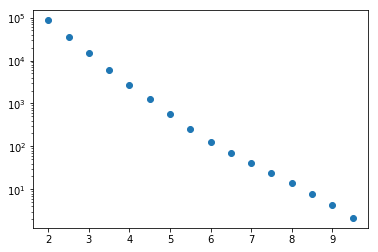

In [840]:
plt.plot(dof, lambdas, 'o')
plt.yscale('log')

In [834]:
MSE = []
thetas = []
for l in lambdas:
    theta, jac, d, msg, ok = leastsq(ridge(l), [0]*len(variables), full_output=True)
    thetas.append(theta)
    MSE.append(np.mean((data['quality'] - f_ridge(data, *theta))**2))

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline

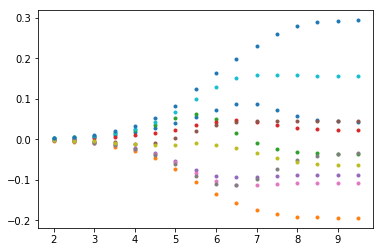

In [843]:
for i in range(len(variables)):
    plt.plot(dof, [theta[i] for theta in thetas], '.', label=variables[i])
#plt.legend(loc='lower left')

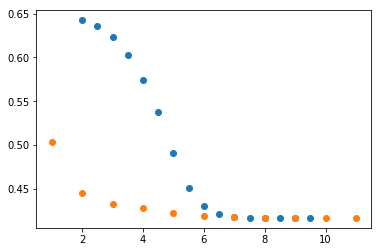

In [842]:
plt.plot(dof, MSE, 'o')
plt.plot(RSS.keys(), [min(RSS[i].values())/len(data.quality) for i in RSS.keys()], 'o')

In [511]:
from scipy.optimize import minimize